# This notebook accompanies Villar et al. (2019): 1905.07422

It shows an example workflow used in the paper, based specifically on the pipeline which worked best for the PS1-MDS dataset of spectroscopically-classified SNe. 

This notebook can also be used as a simple (yet incomplete) guide to classifying supernova light curves

In [232]:
#  Import various modules
import numpy as np
import matplotlib.pyplot as plt
from utils import makeTransients,makeTransientLC,plot_confusion_matrix

#  Also ignore warnings to be pretty-looking :)
import warnings
warnings.filterwarnings('ignore')


## Creating a Synthetic Dataset

First, we will generate a synthetic dataset. For this example, we'll generate two classes of SNe: "Short" and "Long". In the paper, there are five classes of SNe considers: Ia, Ibc, II, IIn, and SLSNe.

We will purposefully make our dataset *unbalanced*. There will be many more Long SNe than Short SNe. In reality, we typically find that Type Ia SNe are the majority class.

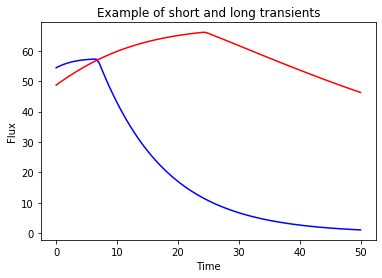

In [233]:
#  Define the total number of transients, and what fraction are "short"
total_number_of_transients = 500
fraction_short = 0.2

short_sne = np.asarray(makeTransients(int(total_number_of_transients * fraction_short),
                                    t1_min=5,t1_max=10,trise_min=3,trise_max=4,
                                    tfall_min=5,tfall_max=20))
long_sne = np.asarray(makeTransients(int(total_number_of_transients * (1. - fraction_short)),
                                    t1_min=20,t1_max=30,trise_min=6,trise_max=10,
                                    tfall_min=30,tfall_max=70))

#  Make a plot of two example light curves
time = np.linspace(0,50,100)
plt.plot(time,makeTransientLC(short_sne.T[0])(time),color='blue')
plt.plot(time,makeTransientLC(long_sne.T[0])(time),color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Example of short and long transients')

#  Generate the final data set by randomly shuffling our SNe and providing labels
#  In this example, we want to extract PCA components from the light curves as
#  features. 
#  In our paper, we extracted PCA components from the fitted light curves.
inds = np.random.permutation(np.arange(total_number_of_transients))
params = np.hstack((short_sne,long_sne)).T[inds]
X = np.zeros((total_number_of_transients,len(time)))
for i,thing in enumerate(params):
    X[i,:] = makeTransientLC(thing)(time)
y = np.asarray([0]*len(short_sne.T)+[1]*len(long_sne.T))[inds]


## Extract Features
We will extract PCA features from a *whitened* (i.e., normalized) dataset. 

In Villar et al. , we explore four feature sets. Please see the paper for more details. The features are roughly as follows:

* **Model Parameters**: We use the analytical model parameters directly.
* **Hand-Selected Features**: We extract "hand-selected" features, such as peak and duration.
* **Principal Component Analysis**: We use PCA on the fitted model light curves. *This is the feature set we explore in this example*.
* **Light Curves**: We downsample the light curves and use them as features.

We will purposefully make our dataset unbalanced. There will be many more Long SNe than Short SNe. In reality, we typically find that Type Ia SNe are the majority class.

In [234]:
from sklearn import decomposition

#  Whiten the data (make it have mean 0 and st. dev. 1)
#  Note that sklearn has a whiten function, which performs these steps!
means = np.mean(X,axis=0)
stds = np.std(X,axis=0)
stds[stds==0] = 1.0
X_whiten = (X - means)/stds
#  Do PCA decomposition on the training data, and use those are features
pca = decomposition.PCA(n_components=5)
pca.fit(X_whiten)
X = pca.transform(X_whiten)

## Resample the Data & Train a Random Forest Classifier

We resample our data using the SMOTE algorithm combined with *leave-one-out cross-validation*. In this step, we loop through our dataset, removing just 1 supernova with each iteration. We use the remaining supernovae as our training set.

We augment the training set using SMOTE, forcing the two classes to be balanced. 

We then train a *random forest classifier* (RF classifier). Note that the hyperparameters should be optimized for a given training set.

Finally, we apply the results of our RF classifier on the "test set", or the SN which we left out of our sample for the current iteration. We then repeat this process for the next SN in our dataset. 

In this way, we build up a predicted classification label ("Short" or "Long") for each of the SNe.

In [235]:
#  Resample the dataset & fit
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut,train_test_split
from sklearn.ensemble import RandomForestClassifier
loo = LeaveOneOut()

y_pred = np.zeros(len(y))

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sampler = SMOTE(random_state=0)
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    Xr_train, Xr_test, yr_train, yr_test = \
        train_test_split(X_res, y_res, test_size=0.33, random_state=42)
    clf = RandomForestClassifier(n_estimators=10, max_depth=None,
                    random_state=42, class_weight='balanced', criterion='entropy',
                                 max_features=4,verbose=False)
    clf.fit(Xr_train,yr_train)
    y_pred[test_index] = clf.predict(X_test)


## Creating the Confusion Matrix

Finally, we can visually our trained model's accuracy using a *confusion matrix*. In each square of this matrix, we compare the fraction of objects which are correctly vs incorrectly classified. Each row of the matrix will add to 1. The diagonal of this matrix gives a quick guideline to the overall performance of the classification pipeline.

Normalized confusion matrix
test2


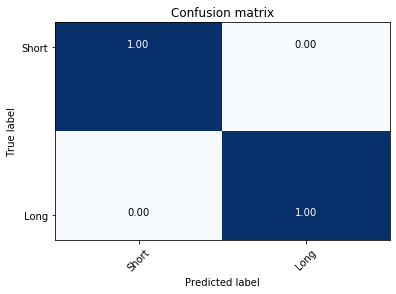

In [236]:
from sklearn.metrics import confusion_matrix

#  Before we plot, we will make labels for both classes
cat_names = ['Short','Long']

cnf_matrix = confusion_matrix(y,y_pred)
plot_confusion_matrix(cnf_matrix, classes=cat_names, normalize=True)